In [ ]:
# steps: 
# create a mask for foreground based on GT images 
# run stats metrics calulation for backgorund layer and for foreground layer separately 

In [21]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import random

import numpy as np

import matplotlib.cm as cm

import pickle

import os, sys

from denoising_assessment_project.utils import metric_compute, stats_compute, stats_plot

# parameters setup 
from denoising_assessment_project.global_vars import global_vars

%matplotlib notebook

import os

In [38]:
%pwd

'/Users/miriamczech/Desktop/denoising_assessment/denoising_assessment_project/notebooks_CARE/beam'

In [22]:
# restoring variables from memory (GT images, indices_eval)
%store -r

In [23]:
# opening GT images 
with open('/Users/miriamczech/Desktop/denoising_assessment/pickled_data/EVAL/un_noised_images_eval_beam.pkl', 'rb') as un_noised_images_eval_beam_pickled:
    un_noised_images = pickle.load(un_noised_images_eval_beam_pickled)

In [24]:
def threshold(un_noised_images_tensor): 
    un_noised_images_tensor_max = torch.amax(un_noised_images_tensor, dim=(3,4))
    un_noised_images_tensor_min = torch.amin(un_noised_images_tensor, dim=(3,4))
    un_noised_images_tensor_range = un_noised_images_tensor_max - un_noised_images_tensor_min
    un_noised_images_tensor_threshold = un_noised_images_tensor_range/5 + un_noised_images_tensor_min
    un_noised_images_tensor_threshold_expanded = un_noised_images_tensor_threshold.unsqueeze(3).unsqueeze(4).expand(un_noised_images_tensor.shape)
    
    image_masks = torch.where(un_noised_images_tensor <= un_noised_images_tensor_threshold_expanded, 0, 1)
    return image_masks 

In [25]:
image_masks = threshold(un_noised_images)

In [26]:
# collecting CARE-predicted images into a tensor, ensuring appropriate image loactions relative to GT images
import glob
import fnmatch
from tifffile import imread

#path at which the predicted images are stored 
path = '/Users/miriamczech/Desktop/denoising_assessment/tiffed_data_beam/predictions/CARE/'

predicted_images = os.listdir(path)
predicted_images_len = len(predicted_images)

print(len(os.listdir(path)))

predicted_images_tensor = torch.zeros_like(un_noised_images)
for n in range(0,20):
    if n in range(0,10):
        n = '0{}'.format(n)
    noised_imgs_n_list = glob.glob(os.path.join(path, '{}_*_*.tif'.format(n)))
    for m in range(0,20):
        if n in range(0,10):
            n = '0{}'.format(n)
        if m in range(0,10):
            m = '0{}'.format(m)
        noised_imgs_m_list = fnmatch.filter(noised_imgs_n_list, os.path.join(path, '{}_{}_*.tif'.format(n, m)))
        for i in range(0,50):
            if n in range(0,10):
                n = '0{}'.format(n)
            if m in range(0,10):
                m = '0{}'.format(m)
            if i in range(0,10):
                i = '0{}'.format(i)
            img_i_path = fnmatch.filter(noised_imgs_m_list, os.path.join(path, '{}_{}_{}.tif'.format(n, m, i)))[0]
            #print(img_i_path)
            xy = torch.tensor(imread(img_i_path))
            n = int(n)
            m = int(m)
            i = int(i)
            predicted_images_tensor[n,m,i,:,:] = xy

20000


In [27]:
# prepare un_noised masked and predicted masked - BACKGROUND

# 0 - background 
# 1 - foreground 

# 1. un_noised masked 
un_noised_background = torch.where(image_masks == 1, 1, un_noised_images)
un_noised_background[un_noised_background == 1] = np.nan

# 2. predicted masked 
predicted_images_tensor_background  = torch.where(image_masks == 1, 1, predicted_images_tensor)
predicted_images_tensor_background[predicted_images_tensor_background== 1] = np.nan

In [28]:
# CARE: -NRMSE BACKGROUND-
# 4a. Computing NRMSE for each GT-CARE_prediction image pair in the data collection
# dims=[m, n, reps]
metric_output = metric_compute.NRMSE_compute(un_noised_background, predicted_images_tensor_background)

# 5. Computing statistics for the metric across all n x m sets 
# dims=[m, n, 2]
metric_stats_NRMSE_CARE_beam_background = stats_compute.set_mean_std_compute(metric_output)

In [29]:
# CARE: -RMSE BACKGROUND-
# 4a. Computing NRMSE for each GT-CARE_prediction image pair in the data collection
# dims=[m, n, reps]
metric_output = metric_compute.RMSE_compute(un_noised_background, predicted_images_tensor_background)

# 5. Computing statistics for the metric across all n x m sets 
# dims=[m, n, 2]
metric_stats_RMSE_CARE_beam_background = stats_compute.set_mean_std_compute(metric_output)

In [30]:
# CARE: -PSNR BACKGROUND-
# 4a. Computing NRMSE for each GT-CARE_prediction image pair in the data collection
# dims=[m, n, reps]
metric_output = metric_compute.PSNR_compute(un_noised_background, predicted_images_tensor_background)

# 5. Computing statistics for the metric across all n x m sets 
# dims=[m, n, 2]
metric_stats_PSNR_CARE_beam_background = stats_compute.set_mean_std_compute(metric_output)

In [31]:
# CARE: -SSIM BACKGROUND-
# 4a. Computing NRMSE for each GT-CARE_prediction image pair in the data collection
# dims=[m, n, reps]
metric_output = metric_compute.SSIM_compute(un_noised_background, predicted_images_tensor_background)

# 5. Computing statistics for the metric across all n x m sets 
# dims=[m, n, 2]
metric_stats_SSIM_CARE_beam_background = stats_compute.set_mean_std_compute(metric_output)

In [32]:
%store metric_stats_NRMSE_CARE_beam_background
%store metric_stats_RMSE_CARE_beam_background
%store metric_stats_PSNR_CARE_beam_background
%store metric_stats_SSIM_CARE_beam_background

Stored 'metric_stats_NRMSE_CARE_beam_background' (Tensor)
Stored 'metric_stats_RMSE_CARE_beam_background' (Tensor)
Stored 'metric_stats_PSNR_CARE_beam_background' (Tensor)
Stored 'metric_stats_SSIM_CARE_beam_background' (Tensor)


<IPython.core.display.Javascript object>


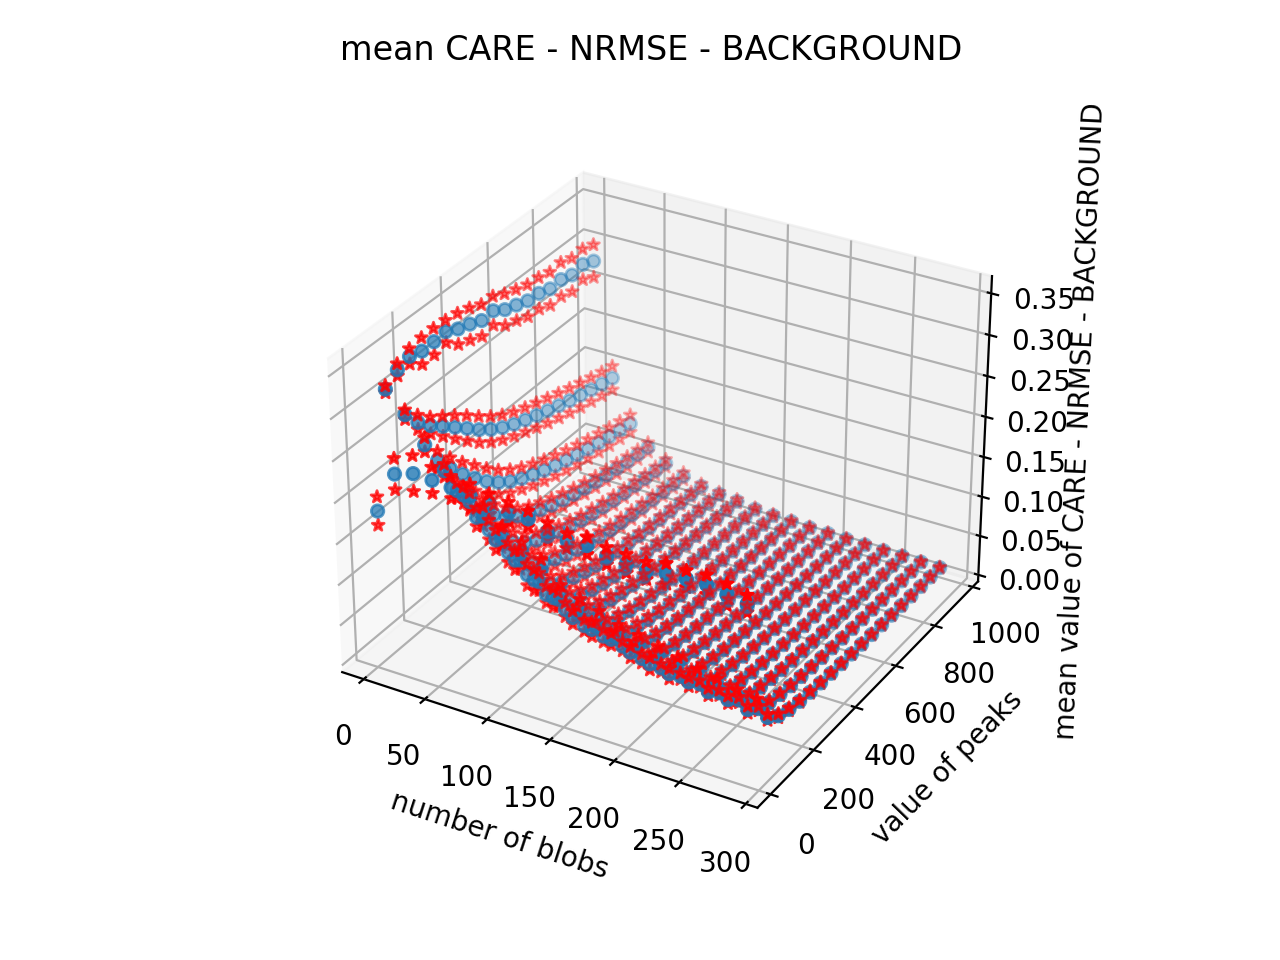

<IPython.core.display.Javascript object>


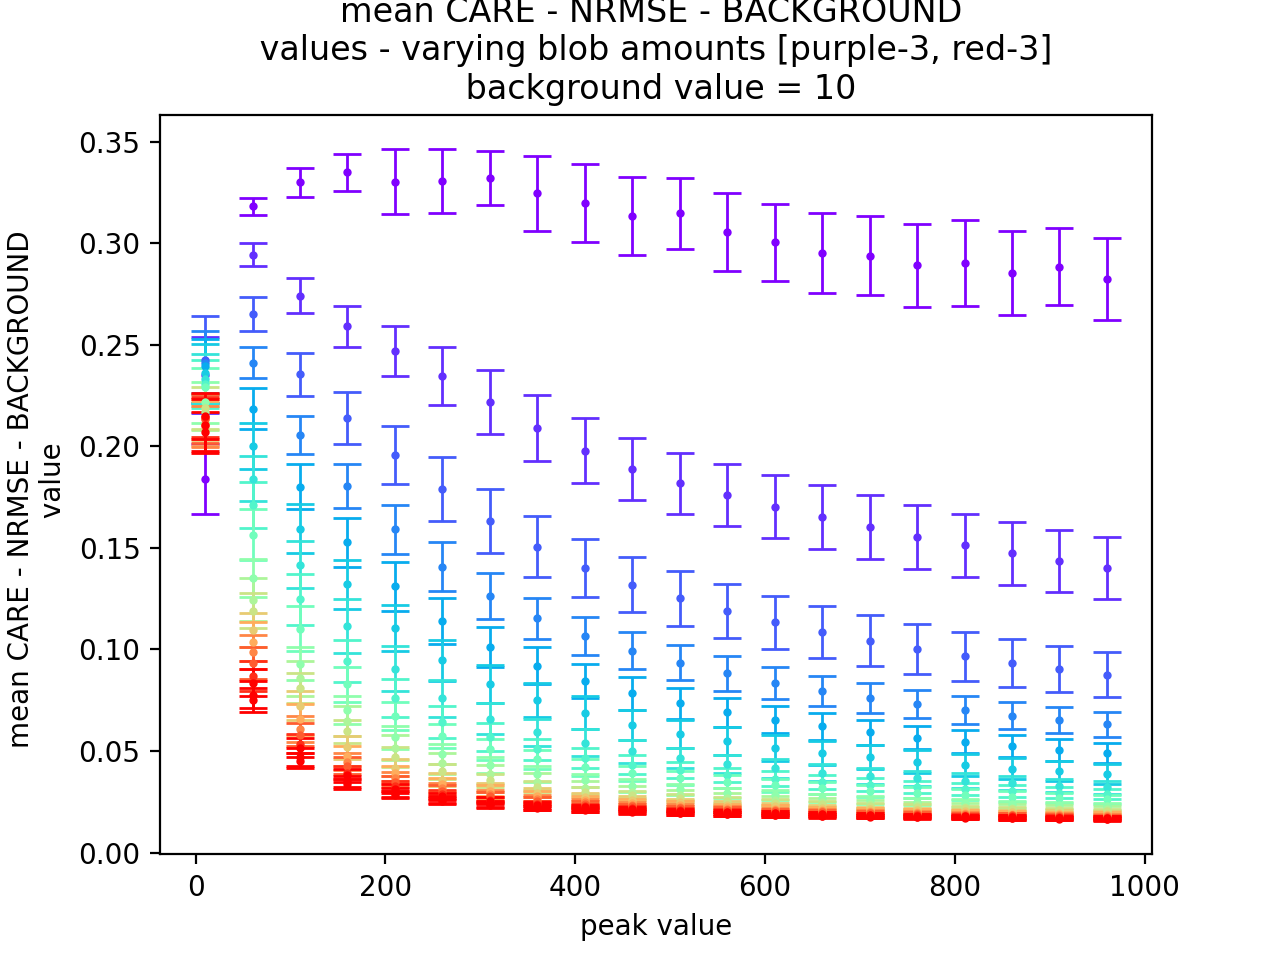

<IPython.core.display.Javascript object>


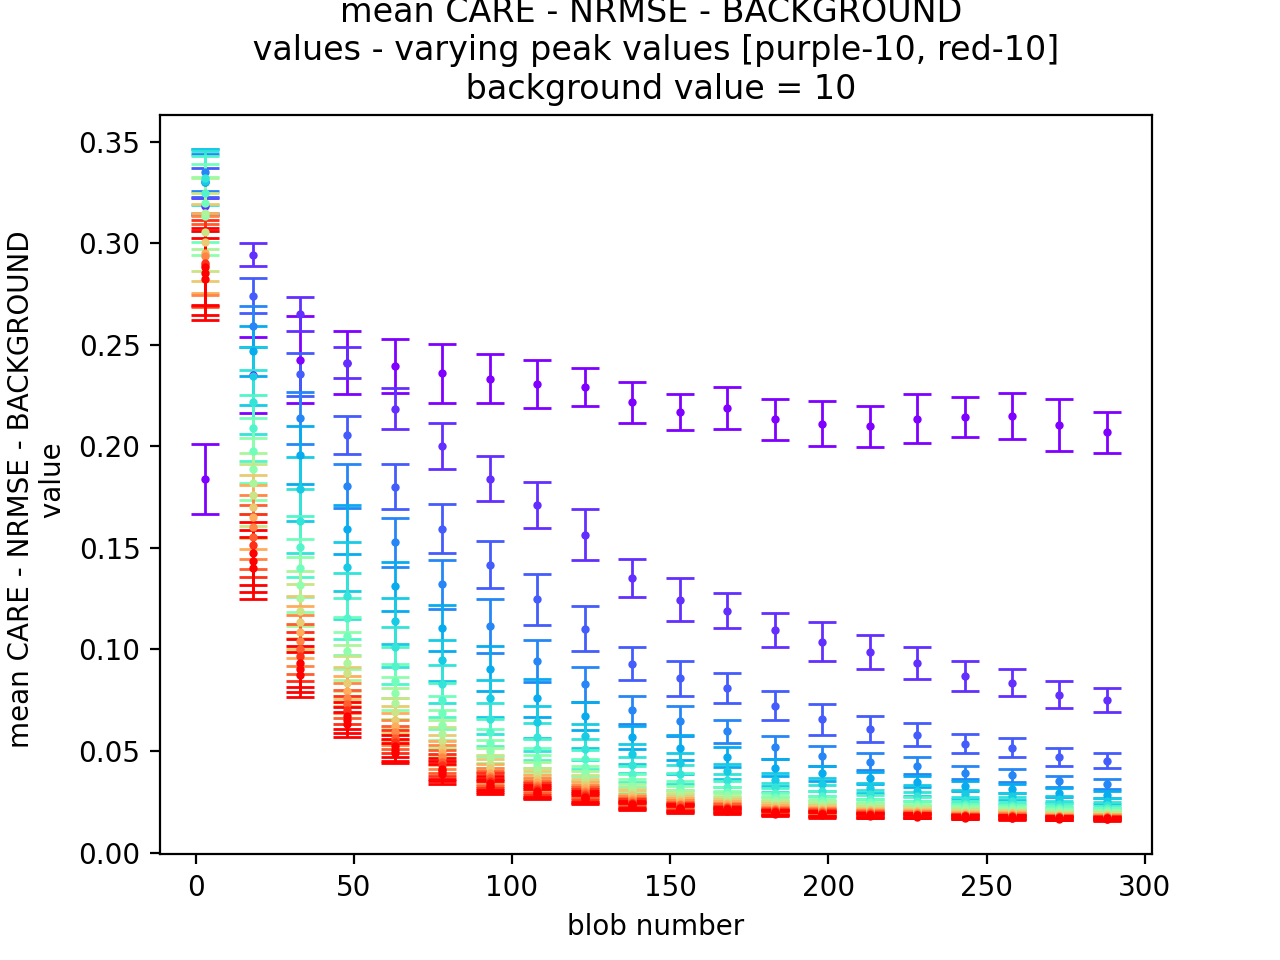

In [33]:
# N2V: -NRMSE BACKGROUND-
# 6. plotting obtained stats
stats_plot.plot_stats(metric_stats_NRMSE_CARE_beam_background, indices_eval, 'CARE - NRMSE - BACKGROUND \n')

<IPython.core.display.Javascript object>


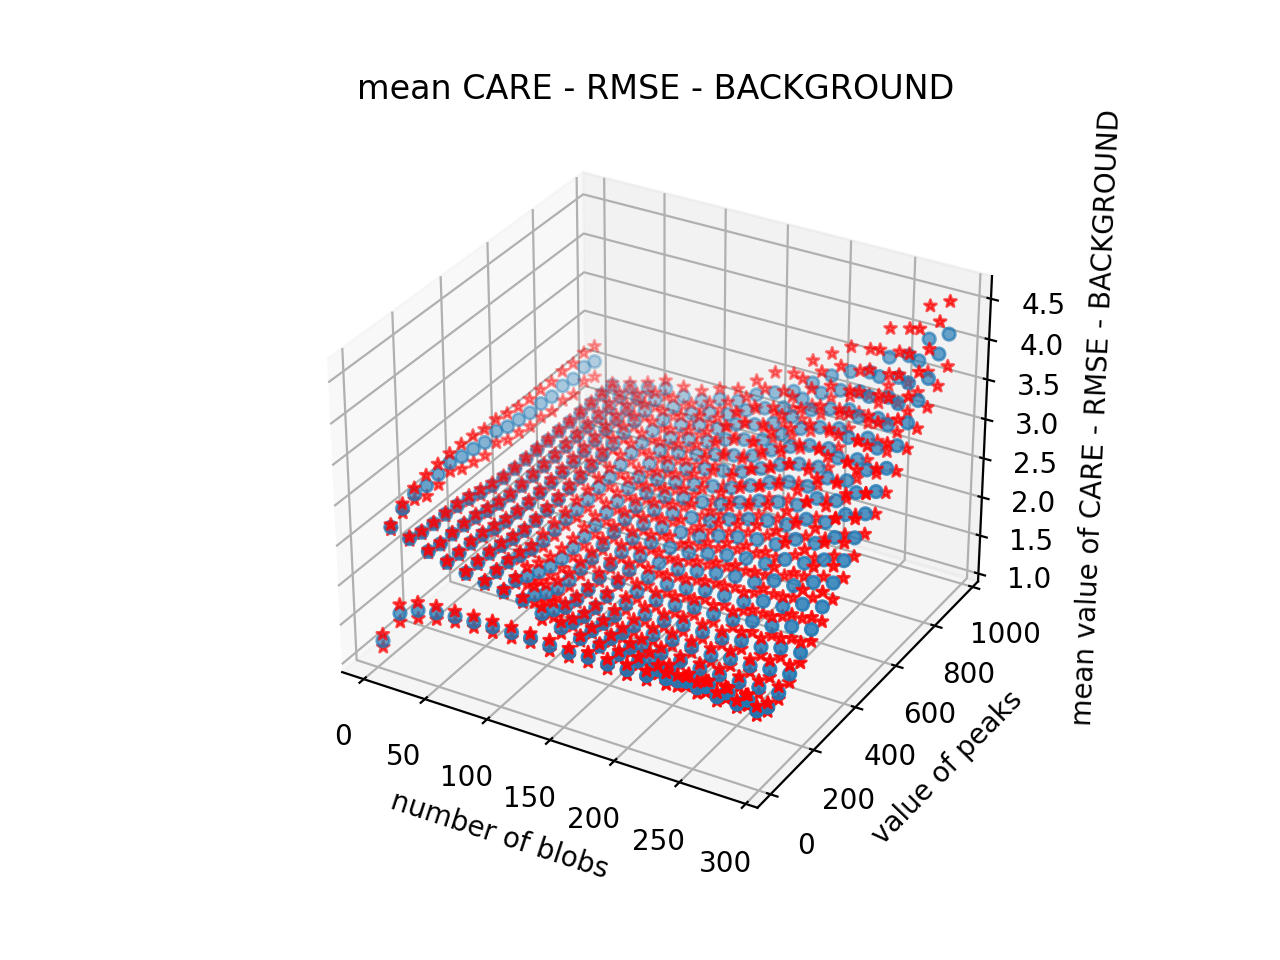

<IPython.core.display.Javascript object>


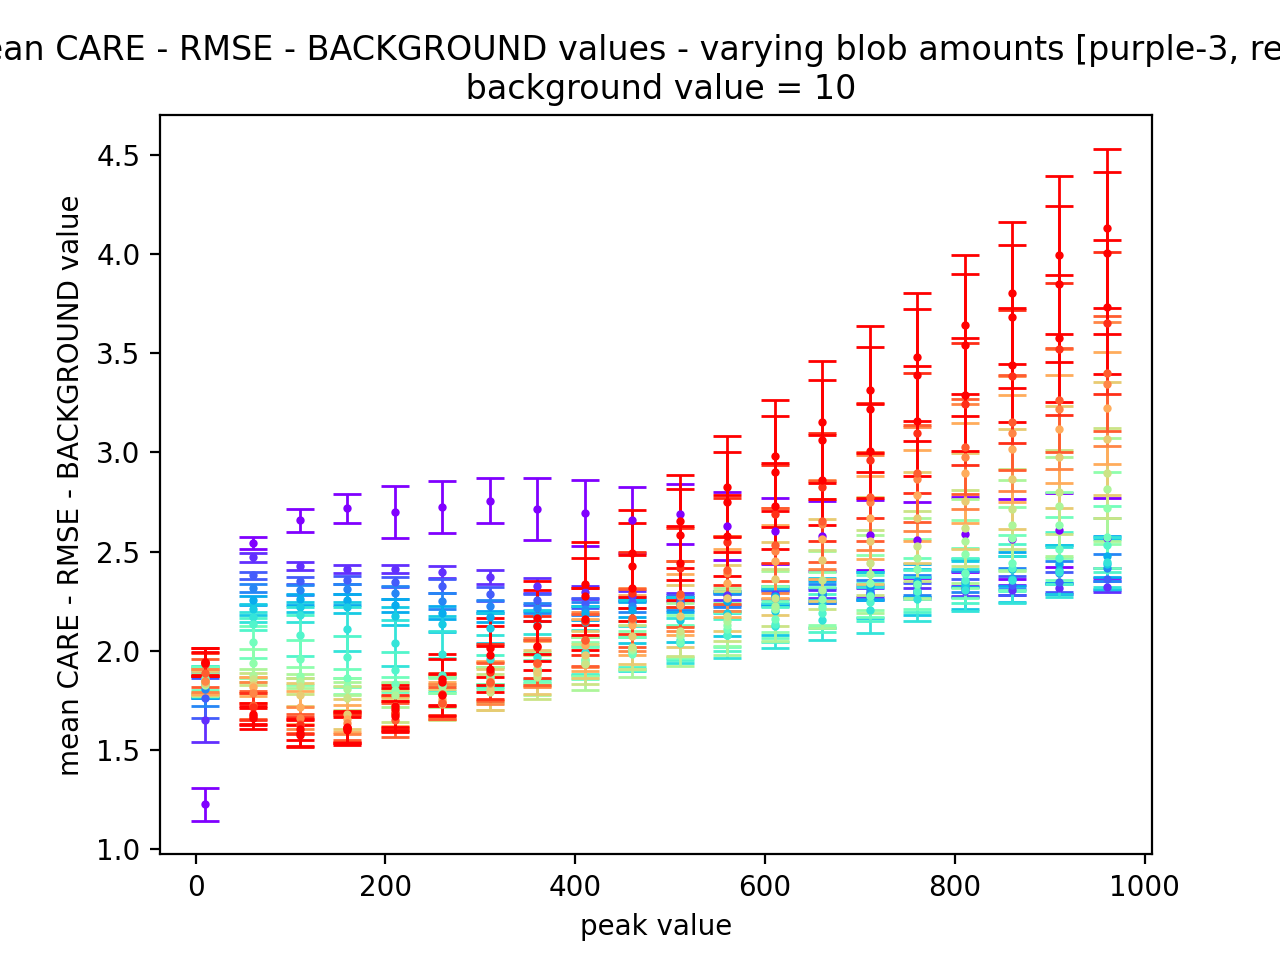

/Users/miriamczech/Desktop/denoising_assessment/denoising_assessment_project/utils/stats_plot.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig3 = plt.figure()


<IPython.core.display.Javascript object>


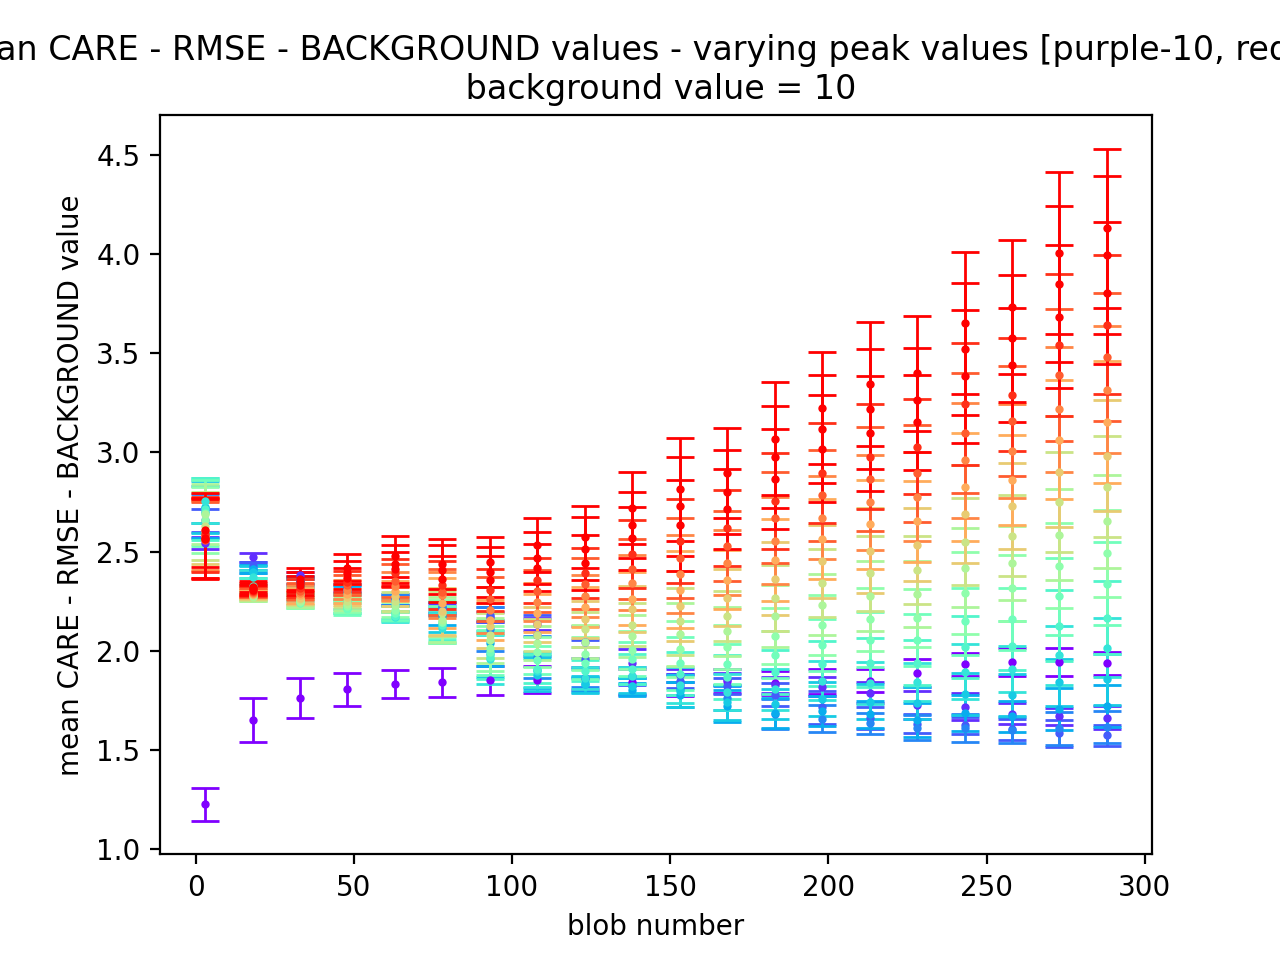

In [34]:
# N2V: -RMSE BACKGROUND-
# 6. plotting obtained stats
stats_plot.plot_stats(metric_stats_RMSE_CARE_beam_background, indices_eval, 'CARE - RMSE - BACKGROUND \n')

<IPython.core.display.Javascript object>


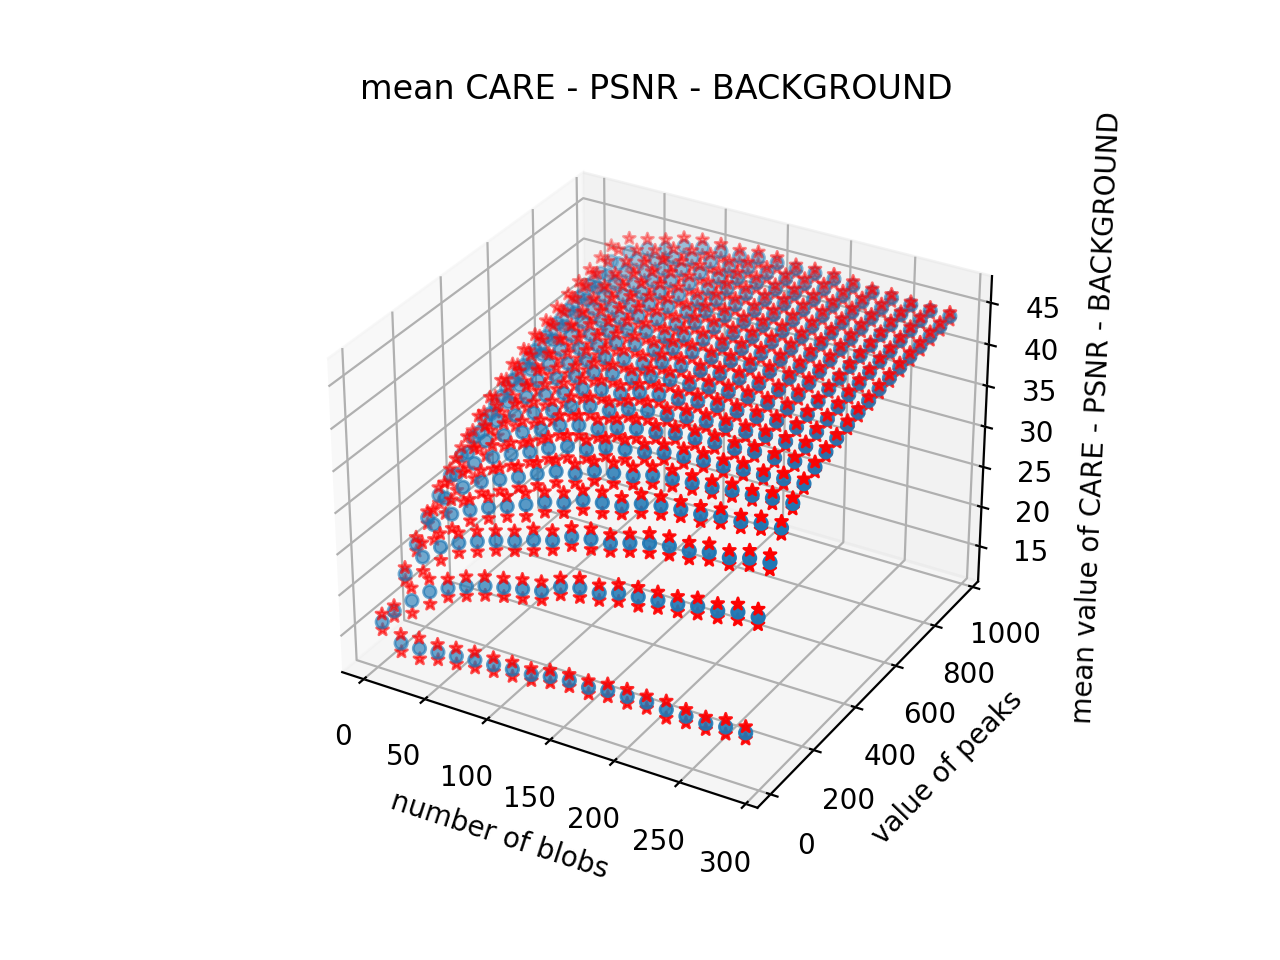

<IPython.core.display.Javascript object>


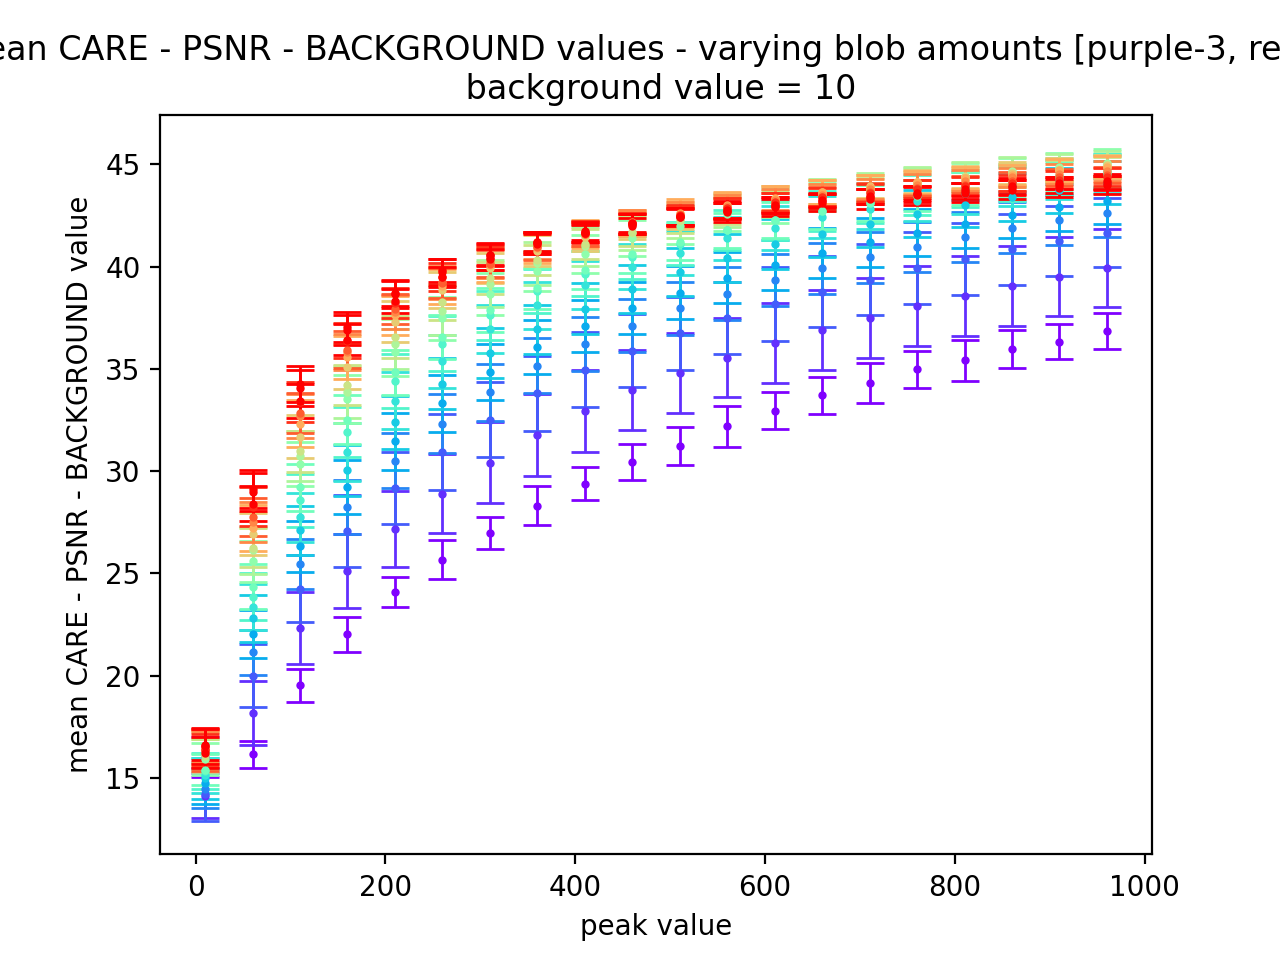

<IPython.core.display.Javascript object>


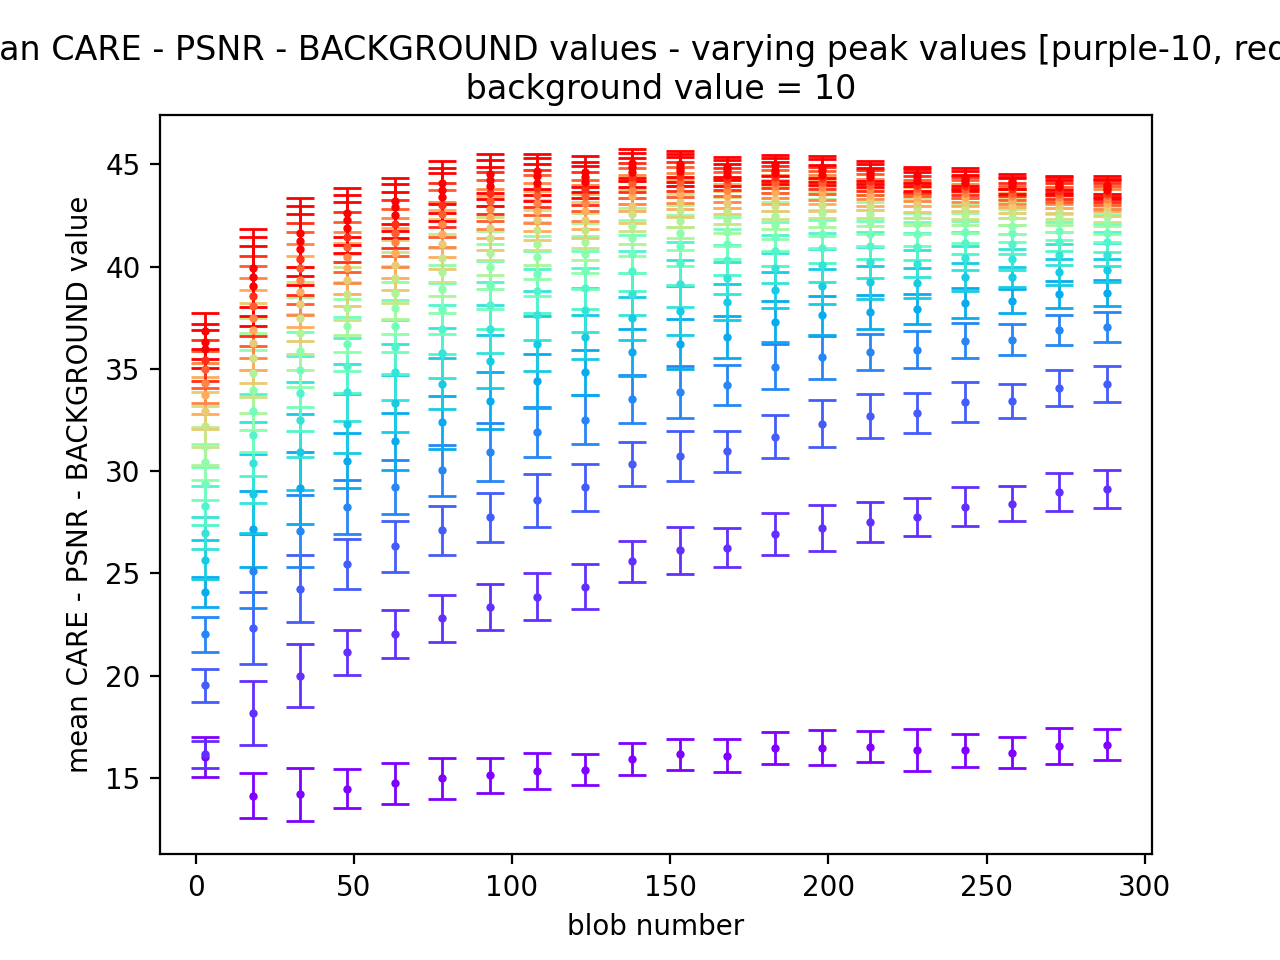

In [35]:
# N2V: -PSNR BACKGROUND-
# 6. plotting obtained stats
stats_plot.plot_stats(metric_stats_PSNR_CARE_beam_background, indices_eval, 'CARE - PSNR - BACKGROUND \n')

<IPython.core.display.Javascript object>


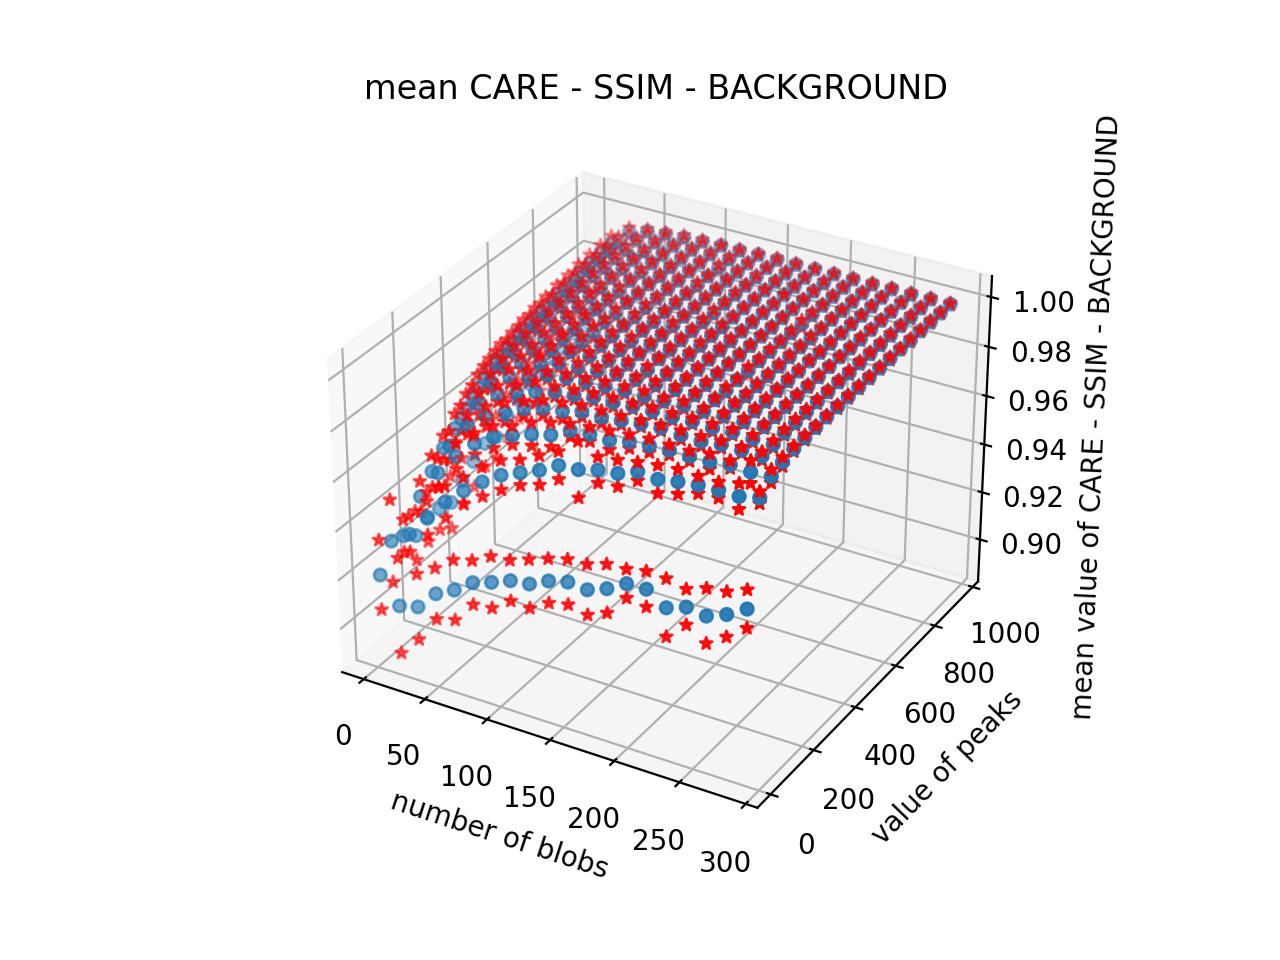

<IPython.core.display.Javascript object>


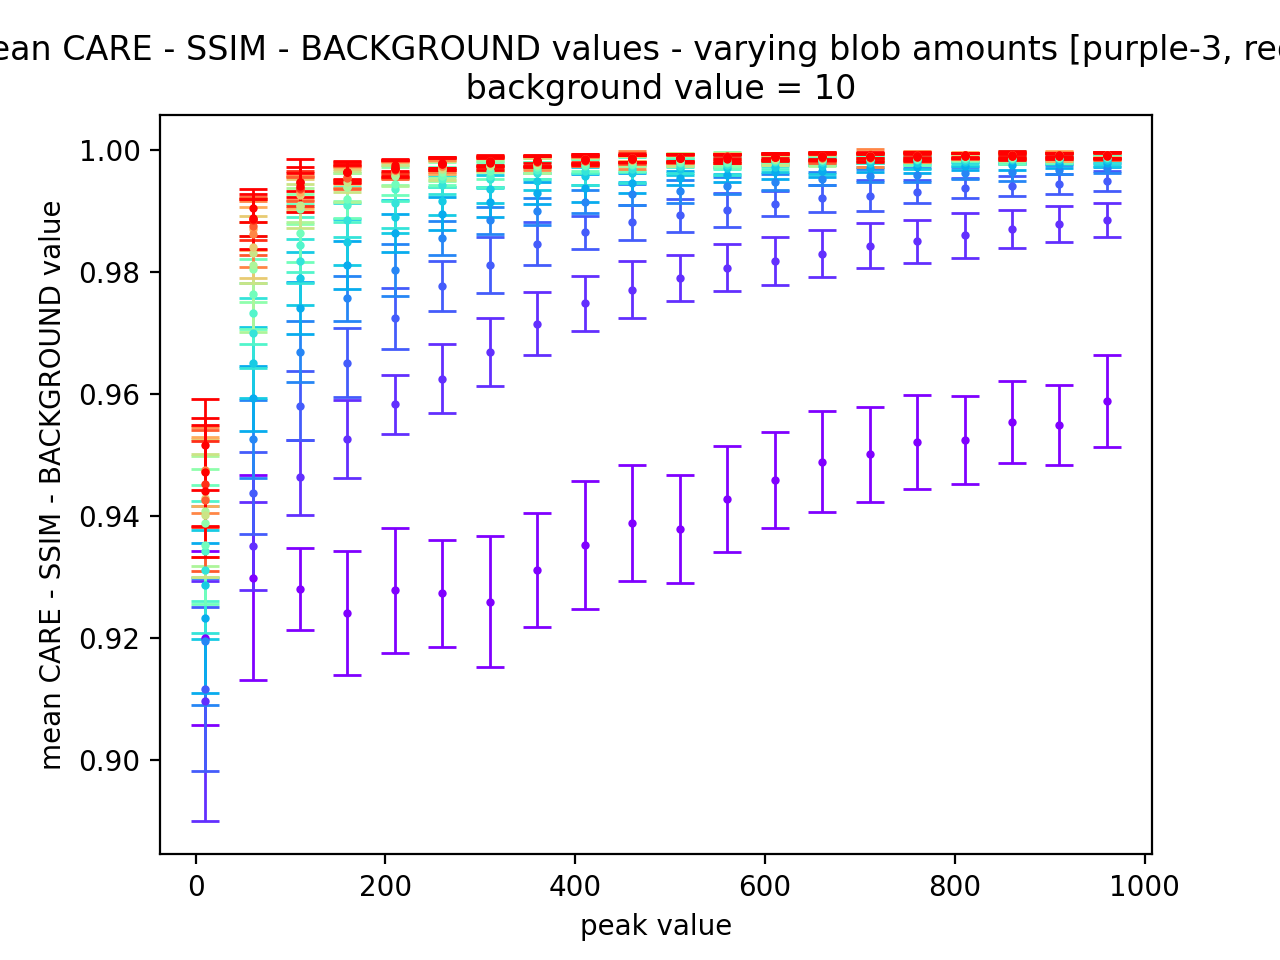

<IPython.core.display.Javascript object>


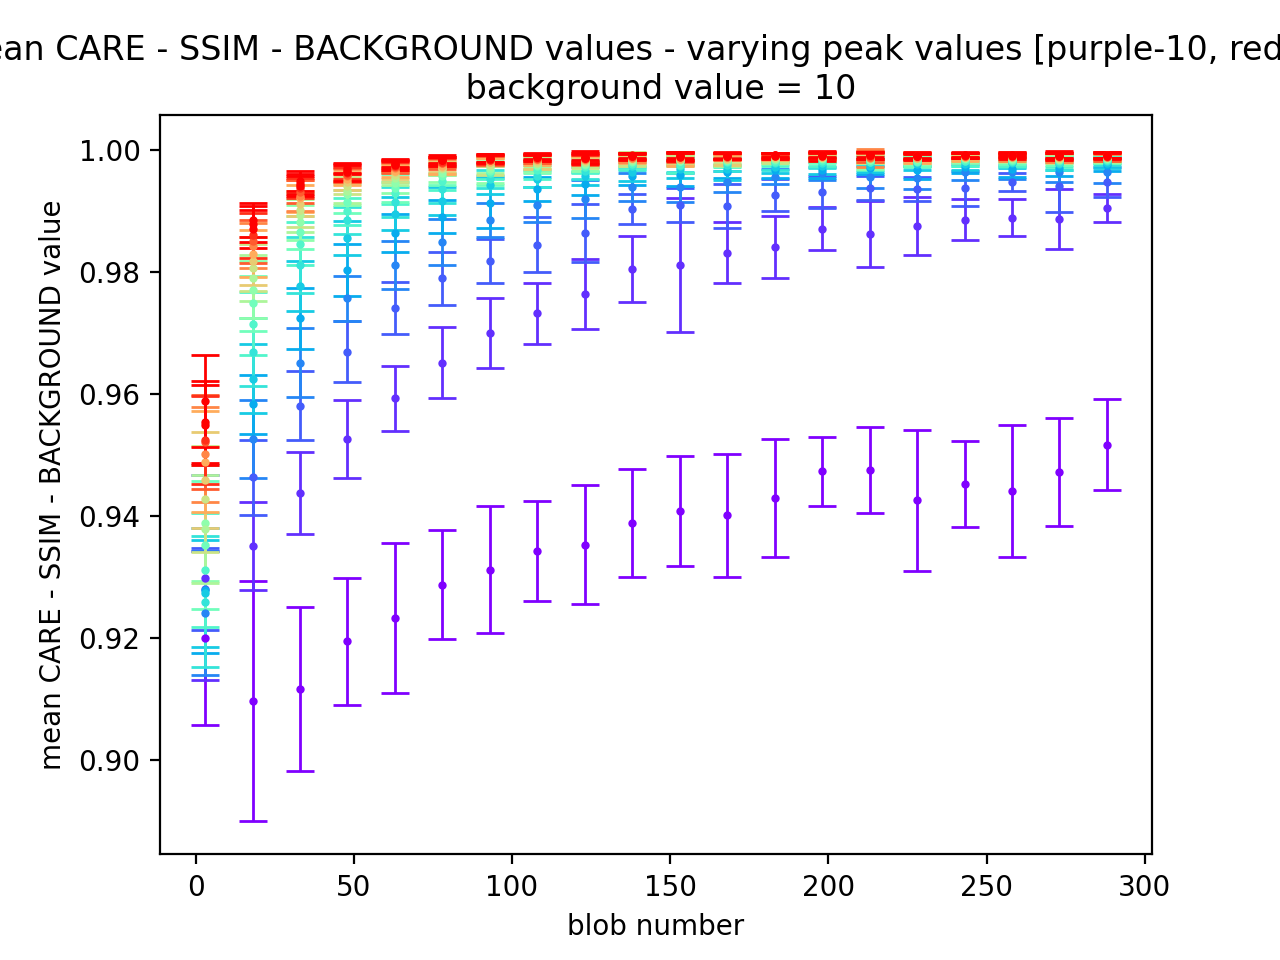

In [36]:
# N2V: -SSIM BACKGROUND-
# 6. plotting obtained stats
stats_plot.plot_stats(metric_stats_SSIM_CARE_beam_background, indices_eval, 'CARE - SSIM - BACKGROUND \n')

In [37]:
%who

DataLoader	 a	 cm	 denoised_with_guassian_pickled	 distinct_blob_quantities	 distinct_blob_quantities_new	 distinct_blob_quantities_pickled_td	 fnmatch	 glob	 
global_vars	 i	 image_masks	 img_i_path	 imread	 indices	 indices_eval	 indices_eval_t2	 indices_eval_zoom	 
indices_eval_zoom_zoom	 indices_td	 indices_td_CAREspecial	 indices_td_zoom	 indices_td_zoom_zoom	 m	 metric_compute	 metric_output	 metric_output_CAREspecial	 
metric_stats	 metric_stats_MS_SSIM	 metric_stats_MS_SSIM_CARE	 metric_stats_MS_SSIM_CARE_beam	 metric_stats_MS_SSIM_CARE_beam_zoom	 metric_stats_MS_SSIM_GB_zoom	 metric_stats_MS_SSIM_N2V	 metric_stats_MS_SSIM_N2V_zoom	 metric_stats_MS_SSIM_N2V_zoom_2	 
metric_stats_MS_SSIM_N2V_zoom_zoom	 metric_stats_MS_SSIM_beam	 metric_stats_MS_SSIM_beam_zoom	 metric_stats_MS_SSIM_beam_zoom_zoom	 metric_stats_MS_SSIM_eval_t2	 metric_stats_NRMSE	 metric_stats_NRMSE_CARE	 metric_stats_NRMSE_CARE_beam	 metric_stats_NRMSE_CARE_beam_background	 
metric_stats_NRMSE_CARE_beam_foregroun